# Interactive notebook on how to build and examine neurodynamic models in PyRates: 

## Setting up a Jansen-Rit-like cortical microcircuit using the Montbrio population model

In this example, it is your task to use PyRates to build a new model of a cortical microcircuit, fusing the architecture of the Jansen-Rit model and the evolution equations for the population dynamics proposed by Montbrió et al. (2015, Phys Rev X). 

Montbrio and colleagues derived a set of two coupled ODEs describing the dynamics of the average firing rate $r$ and membrane potential $v$ of a population of globally coupled quadratic integrate-and-fire neurons. The evolution equations for an excitatory QIF population are given by:

$$\tau \dot r = \frac{\Delta}{\pi\tau} +2 r v$$
$$\tau \dot v = v^2 +\eta + I_{ext}(t) + J s \tau - (\pi r \tau)^2$$

With $\tau$ being the evolution time constant,  $J$ is a scalar weight to the synaptic input $s$, $I_{ext}$ is external current, and $\eta$ and $\Delta$ are the average and FWHM of the background input, respectively.

The Jansen-Rit architecture is characterized by the following features:
- 3 interconnected populations: Pyramidal cells, excitatory interneurons and inhibitory interneurons
- Synaptic dynamics are expressed by convolutions with alpha kernels, describing an exponential rise and decay of the synaptic response

The benefit of a QIF-based cortical microcircuit is that neural refractoriness is represented in the single cell model and not lost by the mean-field reduction of Montbrio and colleagues. This leads to more realistic synchronization behavior within populations and allows for an explicit description of the amount of synchrony within a population. Given the extensive use of neural population models to investigate neural synchronization behavior in macroscopic neural networks (i.e. connectome models), this improvement could allow to capture a number of features of neural synchronization dynamics that could not be explained by models like the Jansen-Rit model that provide no direct description of the level of neural synchronization.

So lets start setting up the model.

## Step I: Implementing the Montbrio population dynamics in PyRates

### I.a setting of the operator templates

Your first task is to set up the operators implementing the equations from above. Thereby, you should distinguish between operators for excitatory and inhibitory populations, since we need both of them in the final model. In the cell below, we already provided some of the code required to do this. You just have to fill in the blank spots, marked by `...`.

In [1]:
import numpy as np
from pyrates import OperatorTemplate, clear_frontend_caches

# TODO: implement your solution below
#####################################

# equations for a QIF population
qif = ['d/dt * r = (delta/(pi*tau) + 2.*r*v) /tau',
       'd/dt * v = (v^2 + eta + I_ext + J*s*tau - (pi*r*tau)^2) /tau']

# equation variables
variables = {'delta': 1.0,
             'tau': 1.0,
             'eta': -5.0,
             'J': 15.0,
             'r': 'output',
             'v': 'variable',
             'I_ext': 'input',
             's': 'input'}

# operator setup
qif_op = OperatorTemplate(name='qif_op', path=None, equations=qif, variables=variables)

### I.b setting up the node and circuit templates

Your next task is to create a circuit with a single node representing an excitatory QIF population governed by the above defined excitatory population operator.

In [2]:
from pyrates import NodeTemplate, CircuitTemplate

# TODO: implement your solution below
#####################################

# set up the node template
pop_exc = NodeTemplate(name='E', path=None, operators=[qif_op])

# set up the circuit template
circuit = CircuitTemplate(name='EC', path=None, nodes={'E': pop_exc},
                          edges=[('E/qif_op/r', 'E/qif_op/s', None, {'weight': 1.0})]
                         )

### I.c simulating the population dynamics

Now, let's test whether the circuit behaves as expected, by simulating its behavior given some transient input.

In [3]:
dt = 1e-3                                      # integration step size in s
dts = 1e-2                                     # variable storage sub-sampling step size in s
T = 42.                                        # total simulation time in s
inp = np.zeros((int(T/dt), 1))                 # external input to the population
inp[int(6./dt):int((T-12.)/dt)] = 3.

# TODO: implement you solution below
####################################

# perform a numerical simulation with input delivered to u and recordings of v and r
results = circuit.run(simulation_time=T, 
                      step_size=dt,
                      inputs={"E/qif_op/I_ext": inp},
                      outputs={"r": "E/qif_op/r", 
                               "v": "E/qif_op/v"},
                      sampling_step_size=dts,
                      in_place=False,
                      clear=True
                      )

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 0.7048687519854866s.


### I.d visualizing the simulation results

This simulation should procude output timeseries equivalent to those shown below. Execute the next cell to visualize your simulation results and see whether they look alike.

<img src="img/qif_exc.svg">

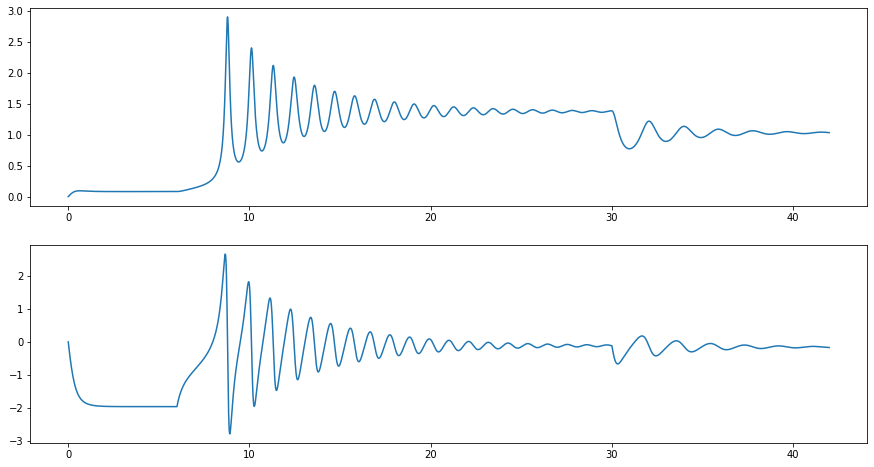

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, figsize=(15, 8))

# TODO: Implement your solution below
#####################################

# plot the firing rate in one axis
ax=axes[0]
ax.plot(results['r'])

# plot the membrane potential in the other axis
ax=axes[1]
ax.plot(results['v'])

## Step II: Creating a circuit of 3 interconnected QIF populations

Now that the operators are set up and tested, your task is to create 3 populations like the one above, connect them to a Jansen-Rit like circuit and choose their parameters such that they represent a pyramidal cell, excitatory interneuron and inhibitory interneuron population. The latter leaves some room for exploration/optimization. However, for now we would like the time-scale of the inhibitory population to be twice as long as the one of the excitatory populations. For setting up the connections, a reminder of the basic connectivity profile of the Jansen-Rit model can be found below.

<img src="img/jrc_simple.png" width="300">

### II.a defining the model

In [5]:
# TODO: implement your solution below
#####################################

# set up the population templates
pc = NodeTemplate(name='PC', path=None, operators=[qif_op])
ein = NodeTemplate(name='EIN', path=None, operators={qif_op: {'eta': -2.5}})
iin = NodeTemplate(name='IIN', path=None, operators={qif_op: {'tau': 2.0, 'eta': -2.5}})

# define the edges between the nodes
edges = [('PC/qif_op/r', 'EIN/qif_op/s', None, {'weight': 1.0}),
         ('EIN/qif_op/r', 'PC/qif_op/s', None, {'weight': 1.8}),
         ('PC/qif_op/r', 'IIN/qif_op/s', None, {'weight': 0.25}),
         ('IIN/qif_op/r', 'PC/qif_op/s', None, {'weight': -1.75})]

# set up the circuit template
jrc = CircuitTemplate(name='jrc_simple', path=None, edges=edges,
                      nodes={'PC': pc, 'EIN': ein, 'IIN': iin})

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 0.6506497219961602s.


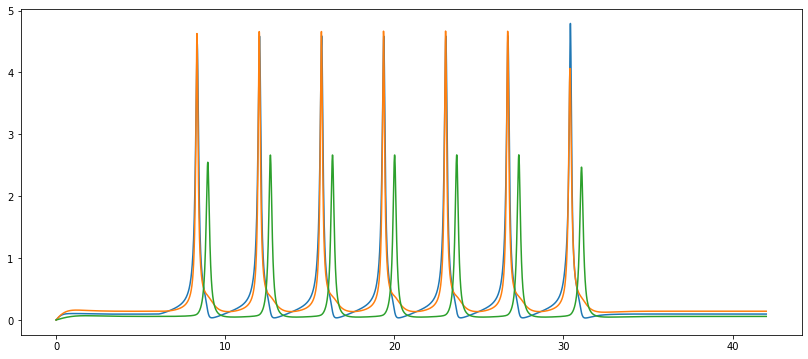

In [6]:
# TODO: implement your solution below
#####################################

# simulate the model behavior with input delivered to the PCs and recordings of all r's
results = jrc.run(simulation_time=T, step_size=dt,
                  outputs={'PC': 'PC/qif_op/r', 
                           'EIN': 'EIN/qif_op/r', 
                           'IIN': 'IIN/qif_op/r'}, 
                  inputs={'PC/qif_op/I_ext' : inp},
                  sampling_step_size=dts, in_place=False, clear=True)

# END TODO: Below there is plotting
###################################

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(results)

# clear all template caches
clear_frontend_caches()

### II.b simulating and visualizing the model dynamics

Now, lets simulate the behavior of the 3-population model. Feel free to play around with the parameters of the operators/edges in the cell above and see how it affects the model dynamics. To proceed, fill in the gaps in the cell below.

## Step III: Adding synaptic dynamics to the circuit

To finalize the cortical microcircuit architecture, your task is to add a description of the synaptic response dynamics to each connection in the circuit. To this end, implement a simple, exponentially decaying model to each synapse type in the model (let's distinguish between excitatory and inhibitory synapses for now). The evolution equation of the synaptic current $I_{syn}$ is given by:

$$\dot{I_{syn}} = \sum_n r_n - \frac{I_{syn}}{\tau_{syn}}$$

with $\tau_{syn}$ being the time-scale of the synapse and the sum being defined over all incoming firing rates. This adds a secondary time-scale to the model, which we could choose according to some experimental measurements of AMPA or GABA dynamics, for example. However, to stick close to the original Jansen-Rit model, we set the synaptic time-scales equal to the membrane time constants, such that we have one fast excitatory and one slow inhibitory time-scale. 

### III.1 defining the model

Try to re-build the operators from Step I describing the population dynamics to include these synaptic dynamics.

In [7]:
# TODO: implement your solution below
#####################################

# define the equations for the exponential synapse
syn = 'd/dt * s = s_in - s/tau_s'

# define the equation variables (separate time scales for excitation vs. inhibition)
variables_exc = {'s': 'output', 'tau_s': 1.0, 's_in': 'input'}
variables_inh = {'s': 'output', 'tau_s': 2.0, 's_in': 'input'}

# set up separate operator templates for excitatory vs. inhibitory synaptic dynamics
exc_op = OperatorTemplate(name='exc_op', path=None, equations=syn, variables=variables_exc)
inh_op = OperatorTemplate(name='inh_op', path=None, equations=syn, variables=variables_inh)

# redefine the qif operator (has been cleared from cache)
qif_op = OperatorTemplate(name='qif_op', path=None, equations=qif, variables=variables)

And now, let's rebuild the circuit from Step II based on the new operators.

In [8]:
# TODO: implement your solution below
#####################################

# set up the node templates with the respective operators
pc = NodeTemplate(name='pc_syns', path=None, operators=[qif_op, exc_op, inh_op])
ein = NodeTemplate(name='ein_syns', path=None, operators={qif_op: {'eta': -0.5}, exc_op: {}})
iin = NodeTemplate(name='iin_syns', path=None, operators={qif_op: {'eta': -0.5, 'tau': 2.0}, exc_op: {}})

# set up a template of the 3 nodes and their edges
nodes = {'PC': pc, 'EIN': ein, 'IIN': iin}
edges = [('PC/qif_op/r', 'EIN/exc_op/s_in', None, {'weight': 1.0}),
         ('EIN/qif_op/r', 'PC/exc_op/s_in', None, {'weight': 0.8}),
         ('PC/qif_op/r', 'IIN/exc_op/s_in', None, {'weight': 0.25}),
         ('IIN/qif_op/r', 'PC/inh_op/s_in', None, {'weight': -1.75})]

jrc2 = CircuitTemplate(name='jrc_syns', path=None, nodes=nodes, edges=edges)

### III.b simulation and visualization

Again, let's test how the circuit behaves.

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 1.8132180289831012s.


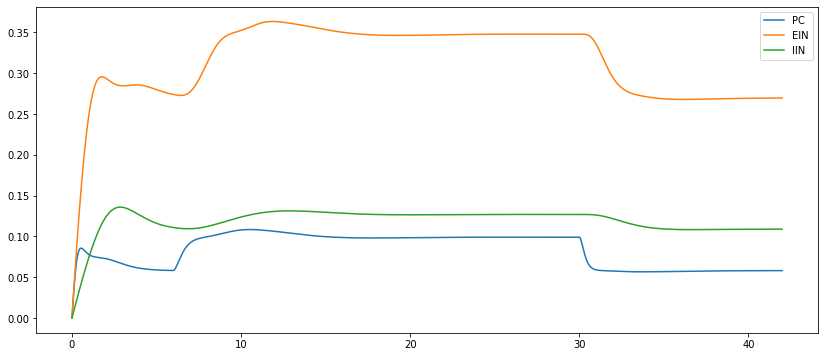

In [9]:
inp = np.zeros((int(T/dt), 1))
inp[int(6./dt):int((T-12.)/dt)] = 5.0

# TODO: implement your solution below
#####################################

# perform a simulation with input delivered to the PCs and recordings of all r's
results = jrc2.run(simulation_time=T, step_size=dt, sampling_step_size=dts,
                   in_place=False, clear=True,
                   outputs={'PC': 'PC/qif_op/r', 
                            'EIN': 'EIN/qif_op/r', 
                            'IIN': 'IIN/qif_op/r'}, 
                   inputs={'PC/qif_op/I_ext': inp})

# END TODO: Below there is plotting
###################################

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(results)
ax.legend(results.columns.values)

# clear all template caches (allows for multiple calls of this cell)
clear_frontend_caches()

## Step IV: Investigating the models parameter space

In a final step, your task is to perform some parameter sweeps to gain an intuition of how different parameters can affect the model dynamics. 

Below, you will find cells with 2 different parameter sweeps. 
One that examines how the model response changes when the strength of the self connections $J$ of each population are altered. Since all three $J$ are changed at the same rate, this is a 1D parameter sweep. 
The other one examines the dependence of the model dynamcis on the connection strengths of the couplings from excitatory and inhibitory population onto the pyramidal cells. Since the connection strengths are altered independently, this results in a 2D parameter sweep. 

Fill in the blanks to get them running.

### IV.a parameter sweep over $J$

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...


/home/rgast/Software/anaconda3/envs/ds/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `step_size`, `vectorization`.
  warn("The following arguments have no effect for a chosen solver: {}."


		...finished after 0.247879523987649s.


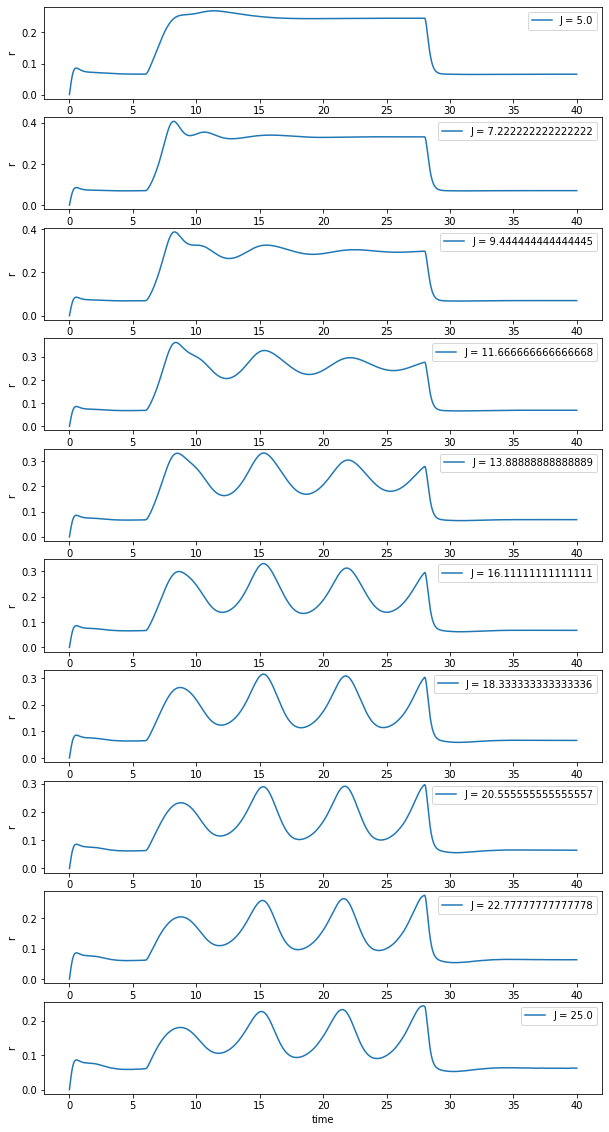

In [10]:
from pyrates import grid_search
import matplotlib.pyplot as plt

# definition of parameter sweep values
Js = np.linspace(5, 25, 10)

# other simulation parameters
T = 40.
dt = 1e-3
dts = 1e-2
inp = np.zeros((int(T/dt), 1))
inp[int(6./dt):int((T-12.)/dt)] = 6.

# TODO: implement your solution below
#####################################

# perform a parameter sweep / grid search over all Js using the model from above
results, params = grid_search(jrc2, param_grid={'J': Js}, 
                              param_map={'J': {'vars': ['qif_op/J'],
                                               'nodes': ['PC', 'EIN', 'IIN']}},
                              simulation_time=T, step_size=dt, sampling_step_size=dts,
                              inputs={'PC/qif_op/I_ext': inp},
                              outputs={'r': 'PC/qif_op/r'},
                              vectorize=True, solver='scipy', in_place=False)

# END TODO: Below there is plotting
###################################

fig, axes = plt.subplots(nrows=len(Js), figsize=(10, 20))
for i, ax in enumerate(axes):
    ax.plot(results.iloc[:, i])
    ax.set_ylabel('r')
    ax.legend([f"J = {params.iloc[0,i]}"], loc='upper right')
ax.set_xlabel('time')

# clear all template caches (allows for multiple calls of this cell)
clear_frontend_caches()

#### IV.b parameter sweep over 2 coupling weights

In [42]:
# definition of parameter sweep values
w_pc_ein = np.linspace(0.5, 2.0, 10)
w_iin_pc = np.linspace(0.5, 2.0, 10)*(-1.75)
J = [18.0]

# other simulation parameters
T = 100.
dt = 1e-3
dts = 1e-2
inp = np.random.uniform(3., 9., (int(T/dt), 1))

# TODO: implement your solution below
#####################################

# perform a parameter sweep / grid search over all combinations of tau_e and tau_i
results, params = grid_search(jrc2, 
                              param_grid={'w_pe': w_pc_ein, 'w_ip': w_iin_pc, 'J': J}, 
                              param_map={'w_pe': {'vars': ['weight'],
                                                  'edges': [('PC/qif_op/r', 'EIN/exc_op/s_in')]},
                                         'w_ip': {'vars': ['weight'],
                                                  'edges': [('IIN/qif_op/r', 'PC/inh_op/s_in')]},
                                         'J': {'vars': ['qif_op/J'],
                                               'nodes': ['PC', 'EIN', 'IIN']}},
                              simulation_time=T, step_size=dt, sampling_step_size=dts,
                              cutoff=20.0,
                              inputs={'PC/qif_op/I_ext': inp},
                              outputs={'r': 'PC/qif_op/r'},
                              vectorize=True, solver='scipy',
                              permute_grid=True, in_place=False)

# clear all template caches (allows for multiple calls of this cell)
clear_frontend_caches()

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...


/home/rgast/Software/anaconda3/envs/ds/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `step_size`, `vectorization`.
  warn("The following arguments have no effect for a chosen solver: {}."


		...finished after 12.790664374013431s.


When the above cell executed without errors, you can run the two cells below to **(a)** calculate the power-spectral densities of the pyramidal cell firing rate fluctuations for each condition, and **(b)** plot the frequency with the highest power and the respective power in 2D parameter maps.

In [43]:
# NO TODO: Below the power spectral density is extracted
########################################################

from scipy.signal import welch

# calculate power-spectral density of firing rate fluctuations
max_freq = np.zeros((len(w_pc_ein), len(w_iin_pc)))
max_pow = np.zeros_like(max_freq)
for key in params.columns.values:
    freqs, power = welch(results.loc[:, key], fs=1/dts, nperseg=256)
    idx_c = np.argwhere(w_pc_ein == params.loc['w_pe', key])[0] 
    idx_r = np.argwhere(w_iin_pc == params.loc['w_ip', key])[0]
    max_idx = np.argmax(power)
    max_freq[idx_r, idx_c] = freqs[max_idx]
    max_pow[idx_r, idx_c] = power[max_idx]

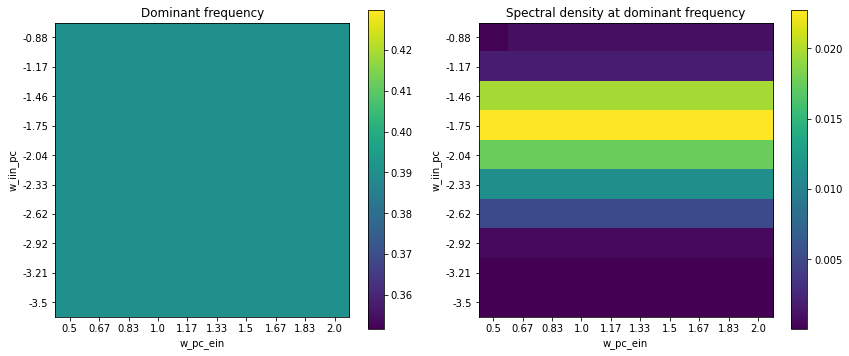

In [44]:
# NO TODO: Below the dominating frequency and its power are plotted
###################################################################

# create 2D plots of maximum frequency and PSD for each parameter set
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# define axis labels
xlabels = np.round(w_pc_ein, decimals=2)
ylabels = np.round(w_iin_pc, decimals=2)

# max frequency
ax = axes[0]
cax = ax.imshow(max_freq, aspect='equal')
ax.set_xticks(np.arange(0, max_freq.shape[1]))
ax.set_yticks(np.arange(0, max_freq.shape[0]))
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)
ax.set_xlabel('w_pc_ein')
ax.set_ylabel('w_iin_pc')
ax.set_title('Dominant frequency')
plt.colorbar(cax, ax=ax)

# spectral density
ax = axes[1]
cax = ax.imshow(max_pow, aspect='equal')
ax.set_xticks(np.arange(0, max_pow.shape[1]))
ax.set_yticks(np.arange(0, max_pow.shape[0]))
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)
ax.set_xlabel('w_pc_ein')
ax.set_ylabel('w_iin_pc')
ax.set_title('Spectral density at dominant frequency')
plt.colorbar(cax, ax=ax)

plt.tight_layout()

If you want to check the raw timeseries corresponding to each point in the 2D grids, you can use the interactive plotting function provided by pyrates. In the first cell below, the backend of matplotlib is changed to allow for interactive plotting. In the last cell, the interactive plot is created. 

In [ ]:
%matplotlib notebook
from pyrates.utility.visualization import Interactive2DParamPlot

In [ ]:
Interactive2DParamPlot(max_freq, results, w_ein_pc, w_iin_pc, params, tmin=30.0, subplots=plt.subplots(ncols=2, nrows=1, figsize=(12, 5)))

Text(0.5, 0, 'time')

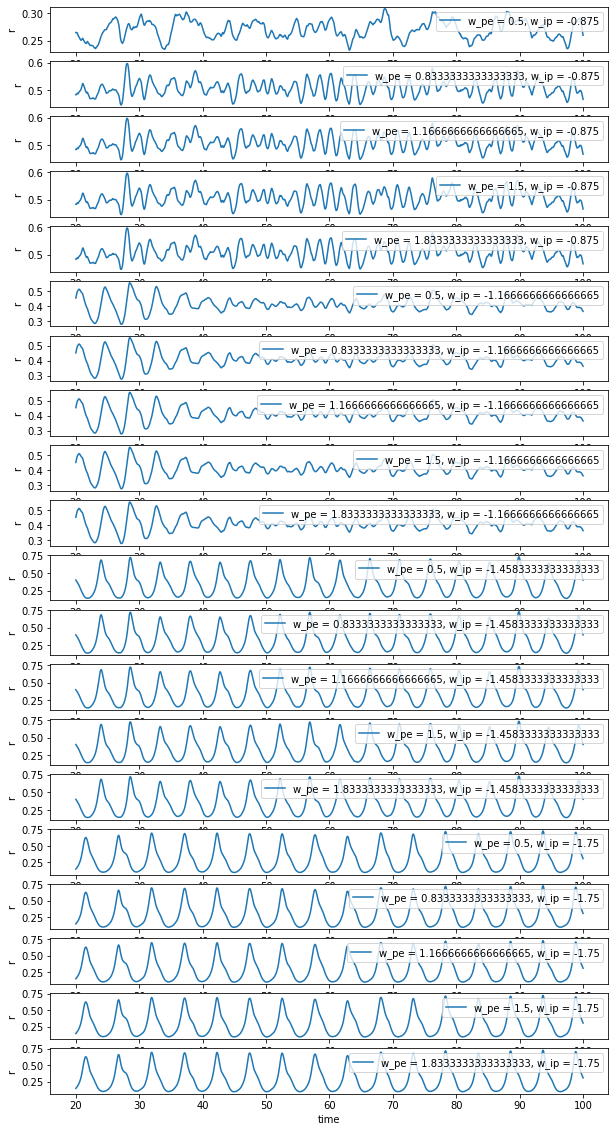

In [45]:
fig, axes = plt.subplots(nrows=20, figsize=(10, 20))
for i, ax in enumerate(axes):
    ax.plot(results.iloc[:, int(i*2)])
    ax.set_ylabel('r')
    ax.legend([f"w_pe = {params.iloc[0,int(i*2)]}, w_ip = {params.iloc[1,int(i*2)]}"], loc='upper right')
ax.set_xlabel('time')